In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import geopandas as gpd
from glob import glob
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('EuroSAFs_pub')

In [3]:
sys.path.insert(1,'../../scripts/optimization/')

In [4]:
import plant_optimization as pop
from plant_optimization.notebook_tools import *

In [5]:
europe_grid = gpd.read_file('../../data/Countries_WGS84/processed/Europe_Evaluation_Grid.shp')
europe_grid.rename(columns={'grid_lat':'lat','grid_lon':'lon'},inplace=True)
europe_grid['sea_node'] = europe_grid.sea_node.astype(bool)
europe_borders = gpd.read_file('../../data/Countries_WGS84/processed/Europe_WGS84.shp')

In [9]:
sensitivity_results_path = os.path.join('../../results/plant_optimization/7e02e76_sensitivity/onshore') # Points to the location of the results csv files
results_path = os.path.join('../../results/plant_optimization/ec6297d_2050/onshore') # Points to the location of the results csv files

In [6]:
specs = pd.read_excel('../../data/plant_assumptions.xlsx',sheet_name='data',index_col=0)
specs = specs.dropna(how='all')

specs_2050 = specs['value_2050'].copy()
specs_2050 = specs_2050.where(~specs_2050.isna(),specs['value_2020'])

specs_names = specs.index

In [7]:
eval_param = [
'CO2_OPEX',
'battery_c_rate',
'heat_lifetime',
'battery_lifetime',
'CO2stor_OPEX',
'CO2_el_efficiency',
'heat_CAPEX',
'H2tL_CAPEX',
'battery_cycle_efficiency',
'electrolyzer_lifetime',
'battery_OPEX',
'H2stor_OPEX',
'PV_OPEX',
'H2tL_OPEX',
'electrolyzer_OPEX',
'battery_CAPEX',
'CO2_lifetime',
'CO2_th_efficiency',
'wind_OPEX',
'H2stor_CAPEX',
'CO2stor_CAPEX',
'CO2_CAPEX',
'PV_CAPEX',
'electrolyzer_CAPEX',
'wind_lifetime',
'H2tL_baseload',
'discount_rate',
'wind_CAPEX',
'electrolyzer_efficiency',
'H2tL_chem_efficiency'
]

# Load Results

In [10]:
# Load all sensitivity results files into a single dataframe
sensitivity = pd.DataFrame()
for file_glob in glob(f'{sensitivity_results_path}/sensitivity*.csv'): 
    sensitivity = sensitivity.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    
# Load all optimization results (with 2050 parameters) into a single dataframe
countries = europe_grid.country.unique()
results_2050_raw = pd.DataFrame()
for country in countries:
    df = pd.DataFrame()
    for file_glob in glob(f'{results_path}/{country}*.csv'): 
        df = df.append(pd.read_csv(file_glob,index_col=0))#.set_index(['lat','lon'])
    df['country'] = country
    results_2050_raw = results_2050_raw.append(df) 
results_2050 = results_2050_raw.drop(columns=[x for x in specs_names if x in results_2050_raw.columns])

# Merge the above two dataframes
combined = gpd.GeoDataFrame(sensitivity.merge(results_2050,on=['lat','lon','country','shore_designation'],how='left',suffixes=('_sensi','_2050')))
combined['sea_node'] = combined.apply(lambda x: True if x.shore_designation=='offshore' else False, axis=1)
combined_gdf = gpd.GeoDataFrame(combined.merge(europe_grid,on=['lat','lon','country','sea_node'],how='left'))

eval_params = [x for x in combined_gdf.columns if x in specs_names or x in ['wind_CAPEX','wind_OPEX']]
eval_params = [x for x in eval_params if combined_gdf[x].max()!=combined_gdf[x].min()]
eval_params = [x for x in eval_params if combined_gdf[x].isna().sum()==0]

# Normalize all parameter values
for eval_param in eval_params:
    combined_gdf[eval_param] = combined_gdf[eval_param]/specs_2050[eval_param]

# Normalize the LCOF found in the sensitivty analysis relative to that found for the 2050 parameters
combined_gdf['LCOF_liter_norm'] = combined_gdf.LCOF_liter_sensi/combined_gdf.LCOF_liter_2050

# Set wind column based on turbine class
combined_gdf['wind_CAPEX'] = combined_gdf.apply(lambda x: x[f'wind_{x.wind_class_sensi}_CAPEX'],axis=1)
combined_gdf['wind_OPEX'] = combined_gdf.apply(lambda x: x[f'wind_{x.wind_class_sensi}_OPEX'],axis=1)
combined_gdf.drop(columns=['wind_lo_CAPEX','wind_lo_OPEX','wind_mid_CAPEX','wind_mid_OPEX','wind_hi_CAPEX','wind_hi_OPEX','wind_monopole_CAPEX','wind_monopole_OPEX','wind_jacket_CAPEX','wind_jacket_OPEX','wind_floating_CAPEX','wind_floating_OPEX'],
                  inplace=True)

# Remove outliers
z_score_filter = 3
prev_len = len(combined_gdf)
mask = abs(combined_gdf.LCOF_liter_norm.mean()-combined_gdf.LCOF_liter_norm)<z_score_filter*combined_gdf.LCOF_liter_norm.std()
combined_gdf = combined_gdf.loc[mask]
print(f'{prev_len-len(combined_gdf)} outlier entries were dropped.')

1 outlier entries were dropped.


# Identify correlations

In [12]:
eval_params = [x for x in combined_gdf.columns if x in specs_names or x in ['wind_CAPEX','wind_OPEX']]
eval_params = [x for x in eval_params if combined_gdf[x].max()!=combined_gdf[x].min()]
eval_params = [x for x in eval_params if combined_gdf[x].isna().sum()==0]
ols_reg = pd.DataFrame()
n_digits = 2
for eval_param in eval_params:
    X = combined_gdf[eval_param]
    Y = combined_gdf.LCOF_liter_norm
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    ols_reg = ols_reg.append({
        'Parameter':eval_param,
        'Intercept':results.params.const,
        'Intercept 95% C.I.':f'[{round(results.conf_int().loc["const"][0],n_digits):+.2f},{round(results.conf_int().loc["const"][1],n_digits):+.2f}]',
        'Slope':results.params[eval_param],
        'Slope 95% C.I.':f'[{round(results.conf_int().loc[eval_param][0],n_digits):+.2f},{round(results.conf_int().loc[eval_param][1],n_digits):+.2f}]',
        'R-Squared':results.rsquared,
        'Slope P-Value': results.pvalues[eval_param]
        
#         'rsquared_adj':results.rsquared_adj
    },ignore_index=True)
ols_reg = ols_reg[['Parameter','Slope','Slope 95% C.I.','Intercept','Intercept 95% C.I.','R-Squared', 'Slope P-Value']]

In [13]:
ols_reg.sort_values('R-Squared',ascending=False).reset_index(drop=True)

,Parameter,Slope,Slope 95% C.I.,Intercept,Intercept 95% C.I.,R-Squared,Slope P-Value
0,H2tL_chem_efficiency,-1.153605,"[-1.45,-0.86]",2.166627,"[+1.86,+2.47]",0.416771,1.936380e-11
1,electrolyzer_efficiency,-1.031425,"[-1.39,-0.68]",2.018970,"[+1.66,+2.37]",0.283706,1.300038e-07
2,battery_cycle_efficiency,-0.513531,"[-0.90,-0.13]",1.524826,"[+1.13,+1.92]",0.077331,9.529210e-03
3,H2tL_CAPEX,0.489179,"[+0.10,+0.88]",0.525594,"[+0.14,+0.91]",0.070119,1.374481e-02
4,CO2_OPEX,-0.447320,"[-0.81,-0.08]",1.460419,"[+1.08,+1.84]",0.066231,1.675106e-02
5,wind_CAPEX,0.355124,"[+0.01,+0.70]",0.658330,"[+0.31,+1.00]",0.047358,4.413723e-02
6,electrolyzer_OPEX,-0.300714,"[-0.63,+0.03]",1.307441,"[+0.97,+1.65]",0.037913,7.241367e-02
7,battery_OPEX,0.291896,"[-0.07,+0.66]",0.714878,"[+0.34,+1.09]",0.029197,1.157169e-01
8,CO2stor_CAPEX,0.284892,"[-0.10,+0.67]",0.724134,"[+0.34,+1.11]",0.024996,1.459815e-01
9,H2tL_OPEX,-0.271790,"[-0.64,+0.10]",1.278282,"[+0.90,+1.66]",0.024528,1.498618e-01


In [41]:
latex_table = ols_reg.sort_values('R-Squared',ascending=False).reset_index(drop=True)
latex_table['Slope'] = np.round(latex_table['Slope'],3)
latex_table['Intercept'] = np.round(latex_table['Intercept'],3)
latex_table['R^2 x100'] = np.round(latex_table['R-Squared']*100,2)
latex_table.drop(columns=['R-Squared'], inplace=True)

param_name_map = {
    'H2tL_chem_efficiency': 'Fuel synthesis chemical efficiency',
    'electrolyzer_efficiency': 'Electrolyser efficiency',
    'wind_CAPEX': 'Wind CAPEX',
    'discount_rate': 'Discount rate',
    'H2tL_baseload': 'Fuel synthesis baseload',
    'wind_lifetime': 'Wind lifetime',
    'electrolyzer_CAPEX': 'Electrolyser CAPEX',
    'PV_CAPEX': 'Solar PV CAPEX',
    'CO2_CAPEX': 'DAC CAPEX',
}

latex_table['Variable name'] = latex_table['Parameter']
latex_table['Parameter'] = latex_table['Variable name'].map(param_name_map)
latex_table = latex_table[['Parameter','Variable name','Slope','Slope 95% C.I.','Intercept','Intercept 95% C.I.','R^2 x100']]
latex_table.head(9)

,Parameter,Variable name,Slope,Slope 95% C.I.,Intercept,Intercept 95% C.I.,R^2 x100
0,Fuel synthesis chemical efficiency,H2tL_chem_efficiency,-1.183,"[-1.66,-0.71]",2.200,"[+1.71,+2.69]",39.96
1,Electrolyser efficiency,electrolyzer_efficiency,-0.882,"[-1.47,-0.30]",1.871,"[+1.29,+2.45]",19.72
2,NaN,battery_cycle_efficiency,-0.767,"[-1.28,-0.25]",1.803,"[+1.27,+2.34]",19.47
3,Wind CAPEX,wind_CAPEX,0.580,"[+0.12,+1.04]",0.456,"[-0.00,+0.91]",14.65
4,NaN,electrolyzer_OPEX,-0.435,"[-0.92,+0.05]",1.444,"[+0.95,+1.93]",8.07
5,NaN,CO2_OPEX,-0.460,"[-1.04,+0.13]",1.489,"[+0.87,+2.10]",6.25
6,NaN,H2tL_CAPEX,0.431,"[-0.12,+0.98]",0.589,"[+0.03,+1.15]",6.15
7,NaN,H2tL_OPEX,-0.458,"[-1.05,+0.13]",1.472,"[+0.87,+2.07]",6.06
8,NaN,CO2stor_OPEX,0.460,"[-0.21,+1.13]",0.572,"[-0.08,+1.23]",4.87


In [14]:
# ols_reg.sort_values('R-Squared',ascending=False).reset_index(drop=True).to_csv('../../paper/sensitivity_parameters_export.csv',index=False)
# latex_table.to_latex('../../paper/sensitivity_parameters_export.tex',index=False)

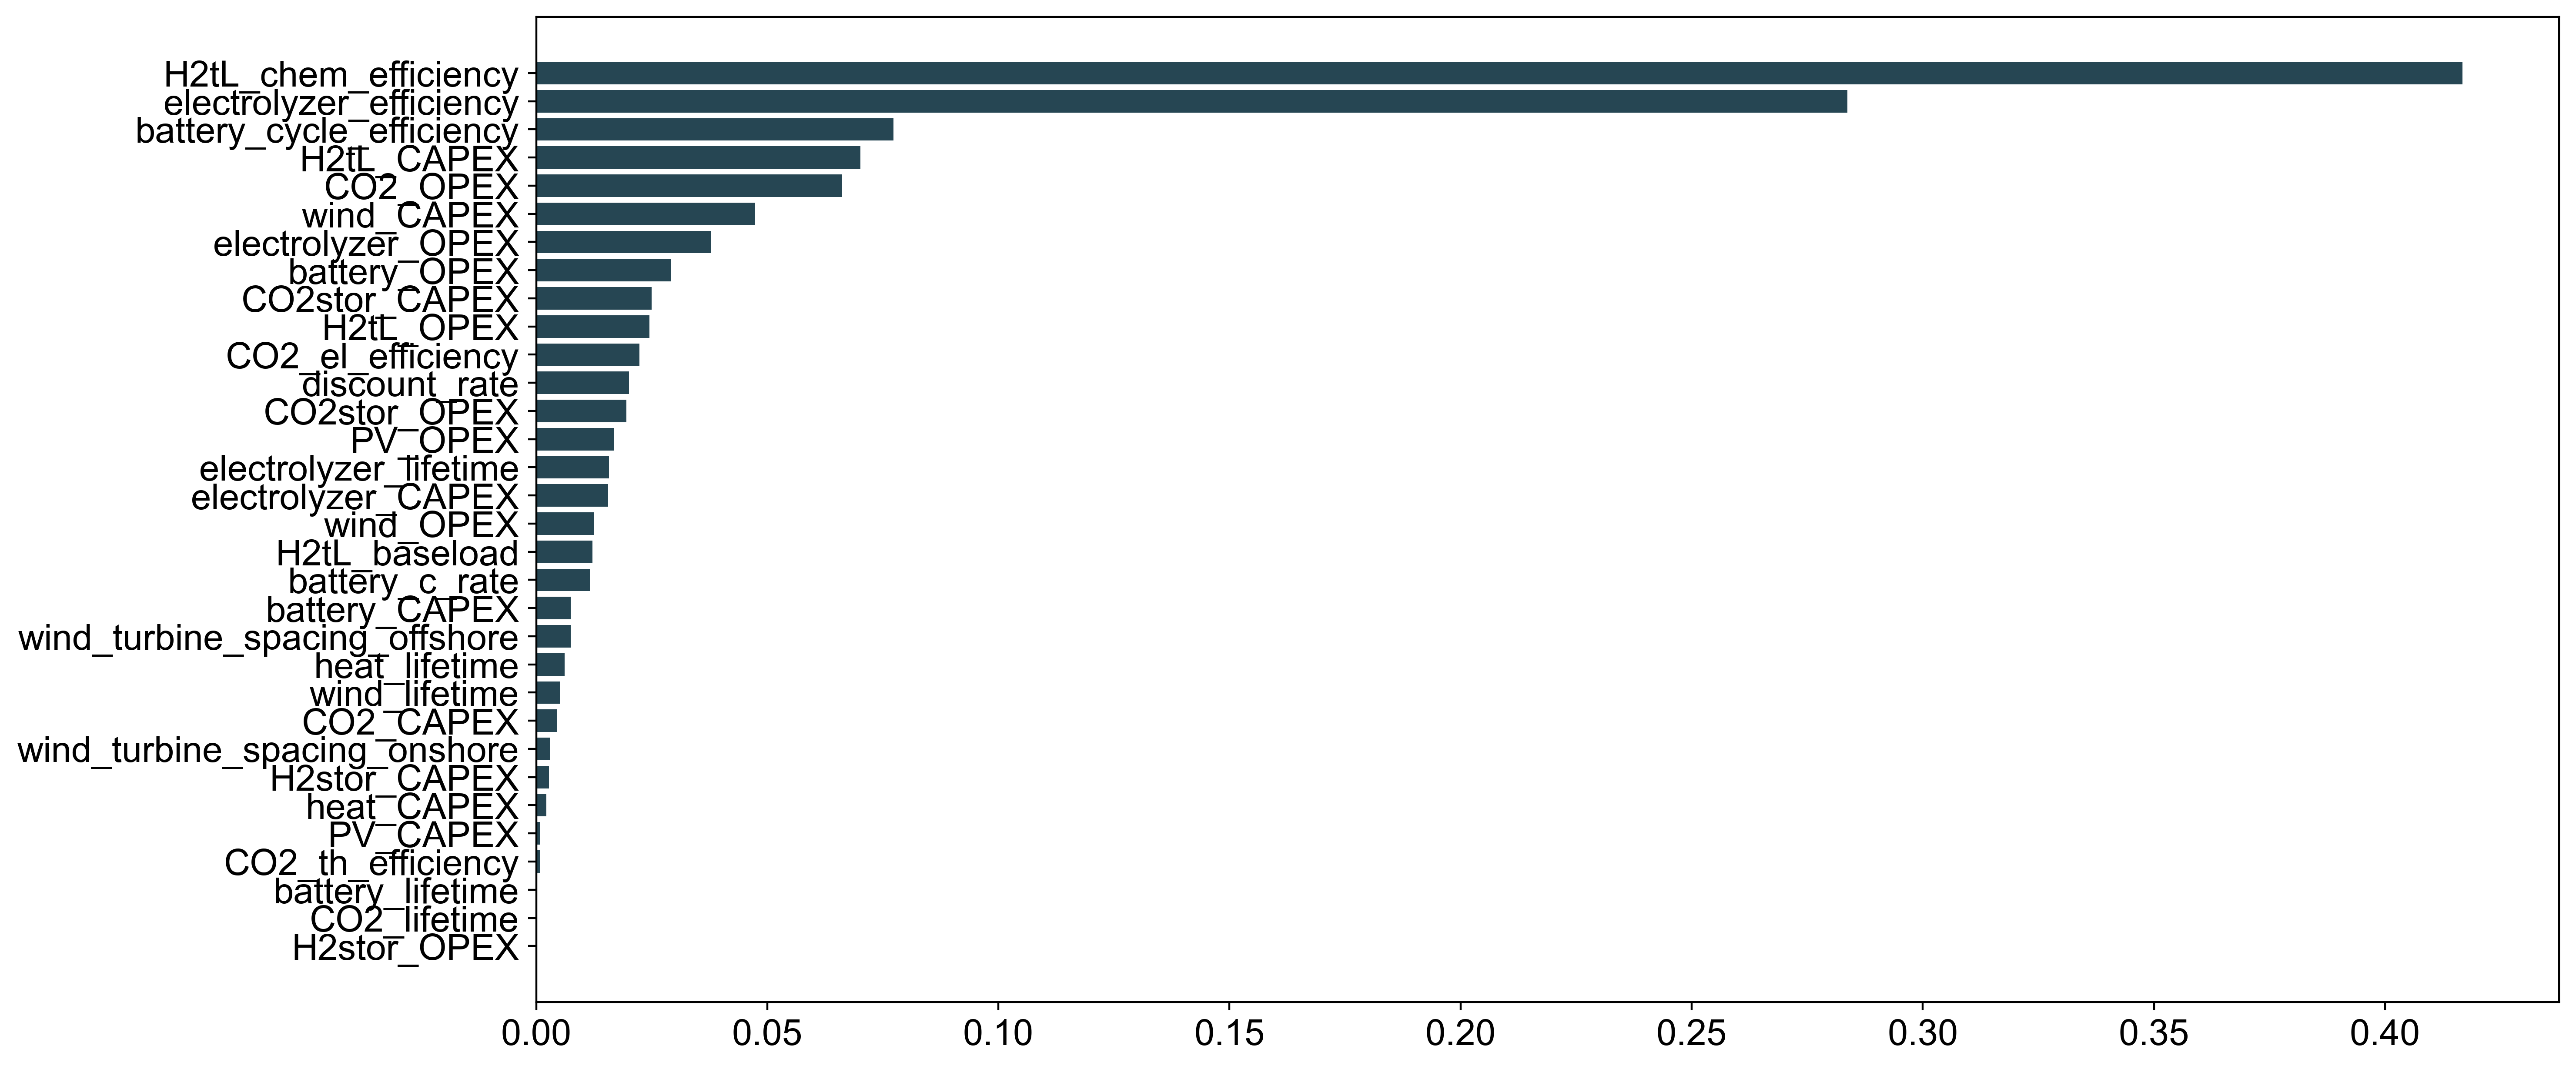

In [14]:
ols_reg_bar = ols_reg.sort_values('R-Squared',ascending=True)
plt.barh(ols_reg_bar.Parameter, ols_reg_bar['R-Squared'], );

KeyError: 'battery_cycle_efficiency'

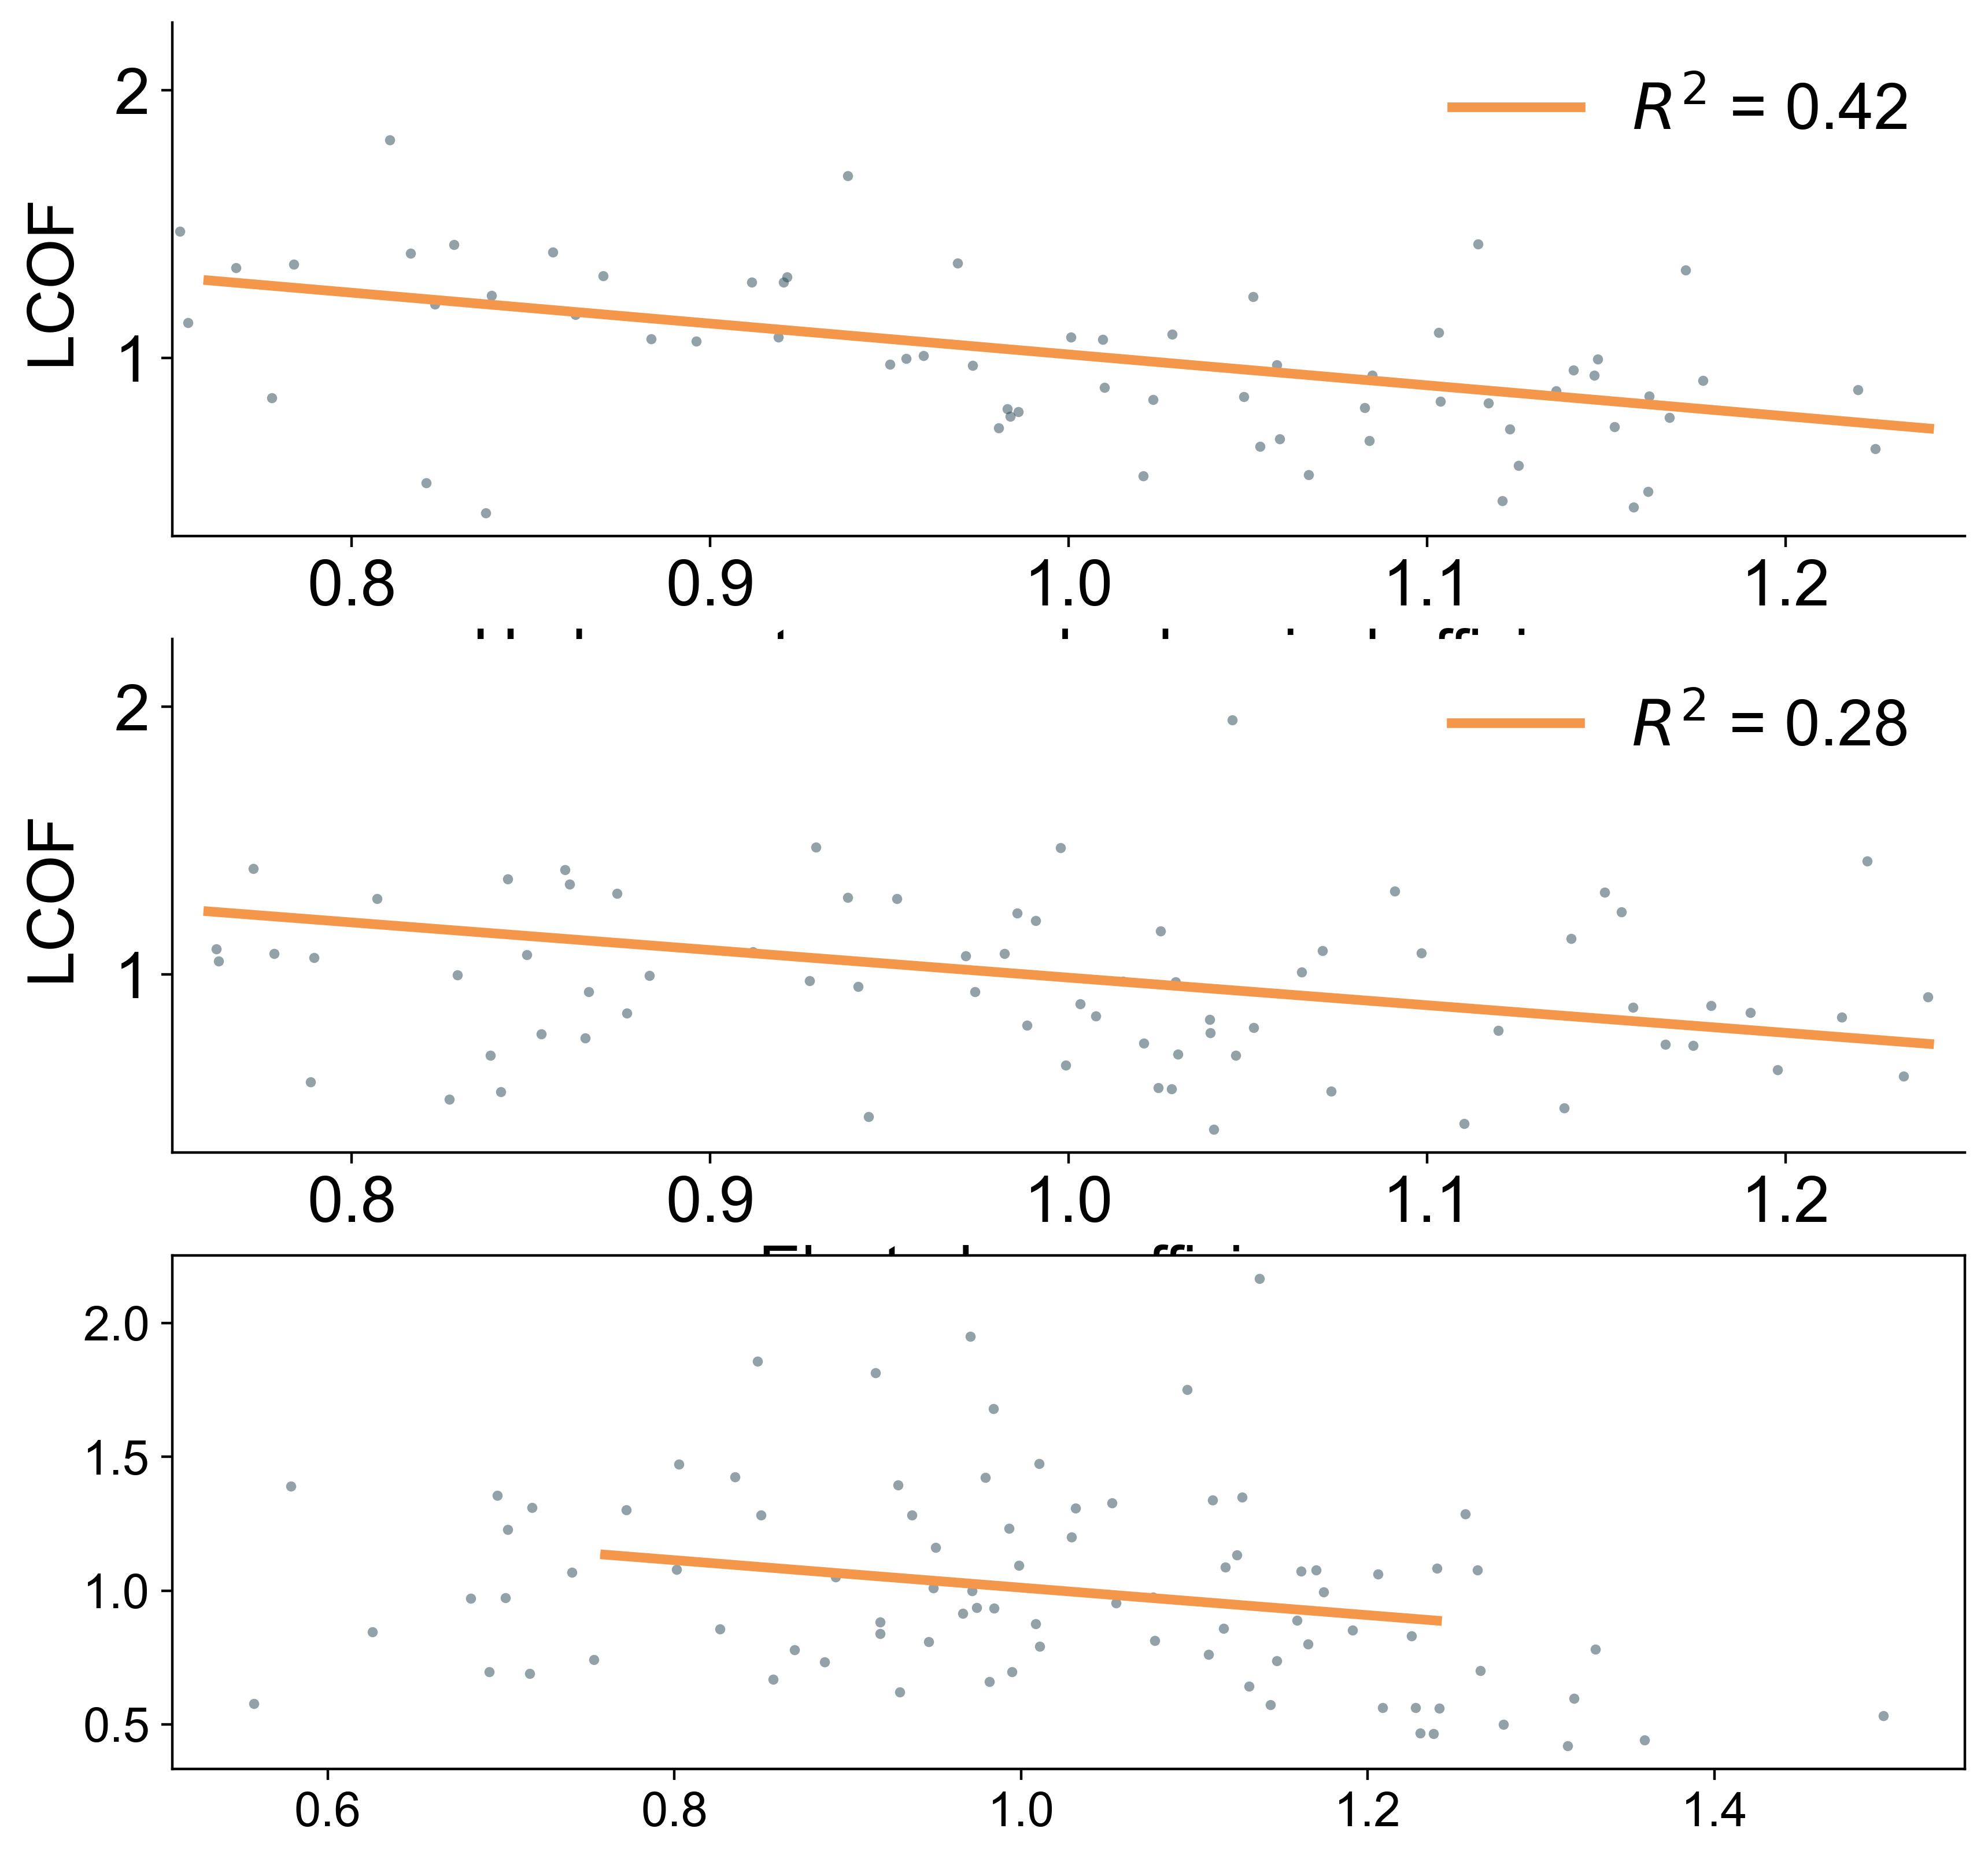

In [15]:
figsize=(10,10)
fontsize=figsize[0]*2
params_count = 3
ncols=1
df = combined_gdf.copy()
ols_reg_slice = ols_reg.loc[ols_reg.Parameter!='discount_rate'].sort_values('R-Squared',ascending=False).iloc[:params_count].reset_index(drop=True).copy()

cmap = 'RdYlGn_r'

titles = {
    'H2tL_chem_efficiency':'Hydrogen-to-syncrude chemical efficiency',
    'electrolyzer_efficiency': 'Electrolyser efficiency',
    'wind_CAPEX': 'Wind turbine CAPEX',
    'electrolyzer_CAPEX': 'Electrolyser CAPEX'
}

if ncols == None:
    ncols = int(np.ceil(np.sqrt(params_count)))
nrows = int(np.ceil(params_count/ncols))    
fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=figsize)
axes = np.reshape(axes,(1,nrows*ncols))[0]
for idx,row in ols_reg_slice.iterrows():
    axes[idx].scatter(df[row.Parameter],df.LCOF_liter_norm, s=10, alpha=0.5, lw=0)#, cmap=cmap, vmin=2, vmax=4, c=df.LCOF_liter_2020)
    minx = 0.75
    maxx = 1.25
    x = np.linspace(0.76,1.24,100)
    y = row.Slope*x + row.Intercept
    axes[idx].plot(x,y,linewidth=3,color='C1',label=fr'$R^{2}$ = {row["R-Squared"]:.2f}')
    axes[idx].set_xlabel(titles[row.Parameter],fontsize=fontsize, labelpad=3)
    axes[idx].tick_params(labelsize=fontsize)
    axes[idx].legend(fontsize=fontsize,framealpha=0, loc='upper right')
    if idx in [x*ncols for x in range(nrows)]:
        axes[idx].set_ylabel('LCOF',labelpad=10,fontsize=fontsize)
    
    axes[idx].spines['top'].set_visible(False)
    axes[idx].spines['right'].set_visible(False)
    axes[idx].set_xlim(minx,maxx)
plt.subplots_adjust(hspace=0.75)
# plt.savefig('../../gfx/highest_sensitivities.png',dpi=400,bbox_inches='tight')

# LCOF Distribution

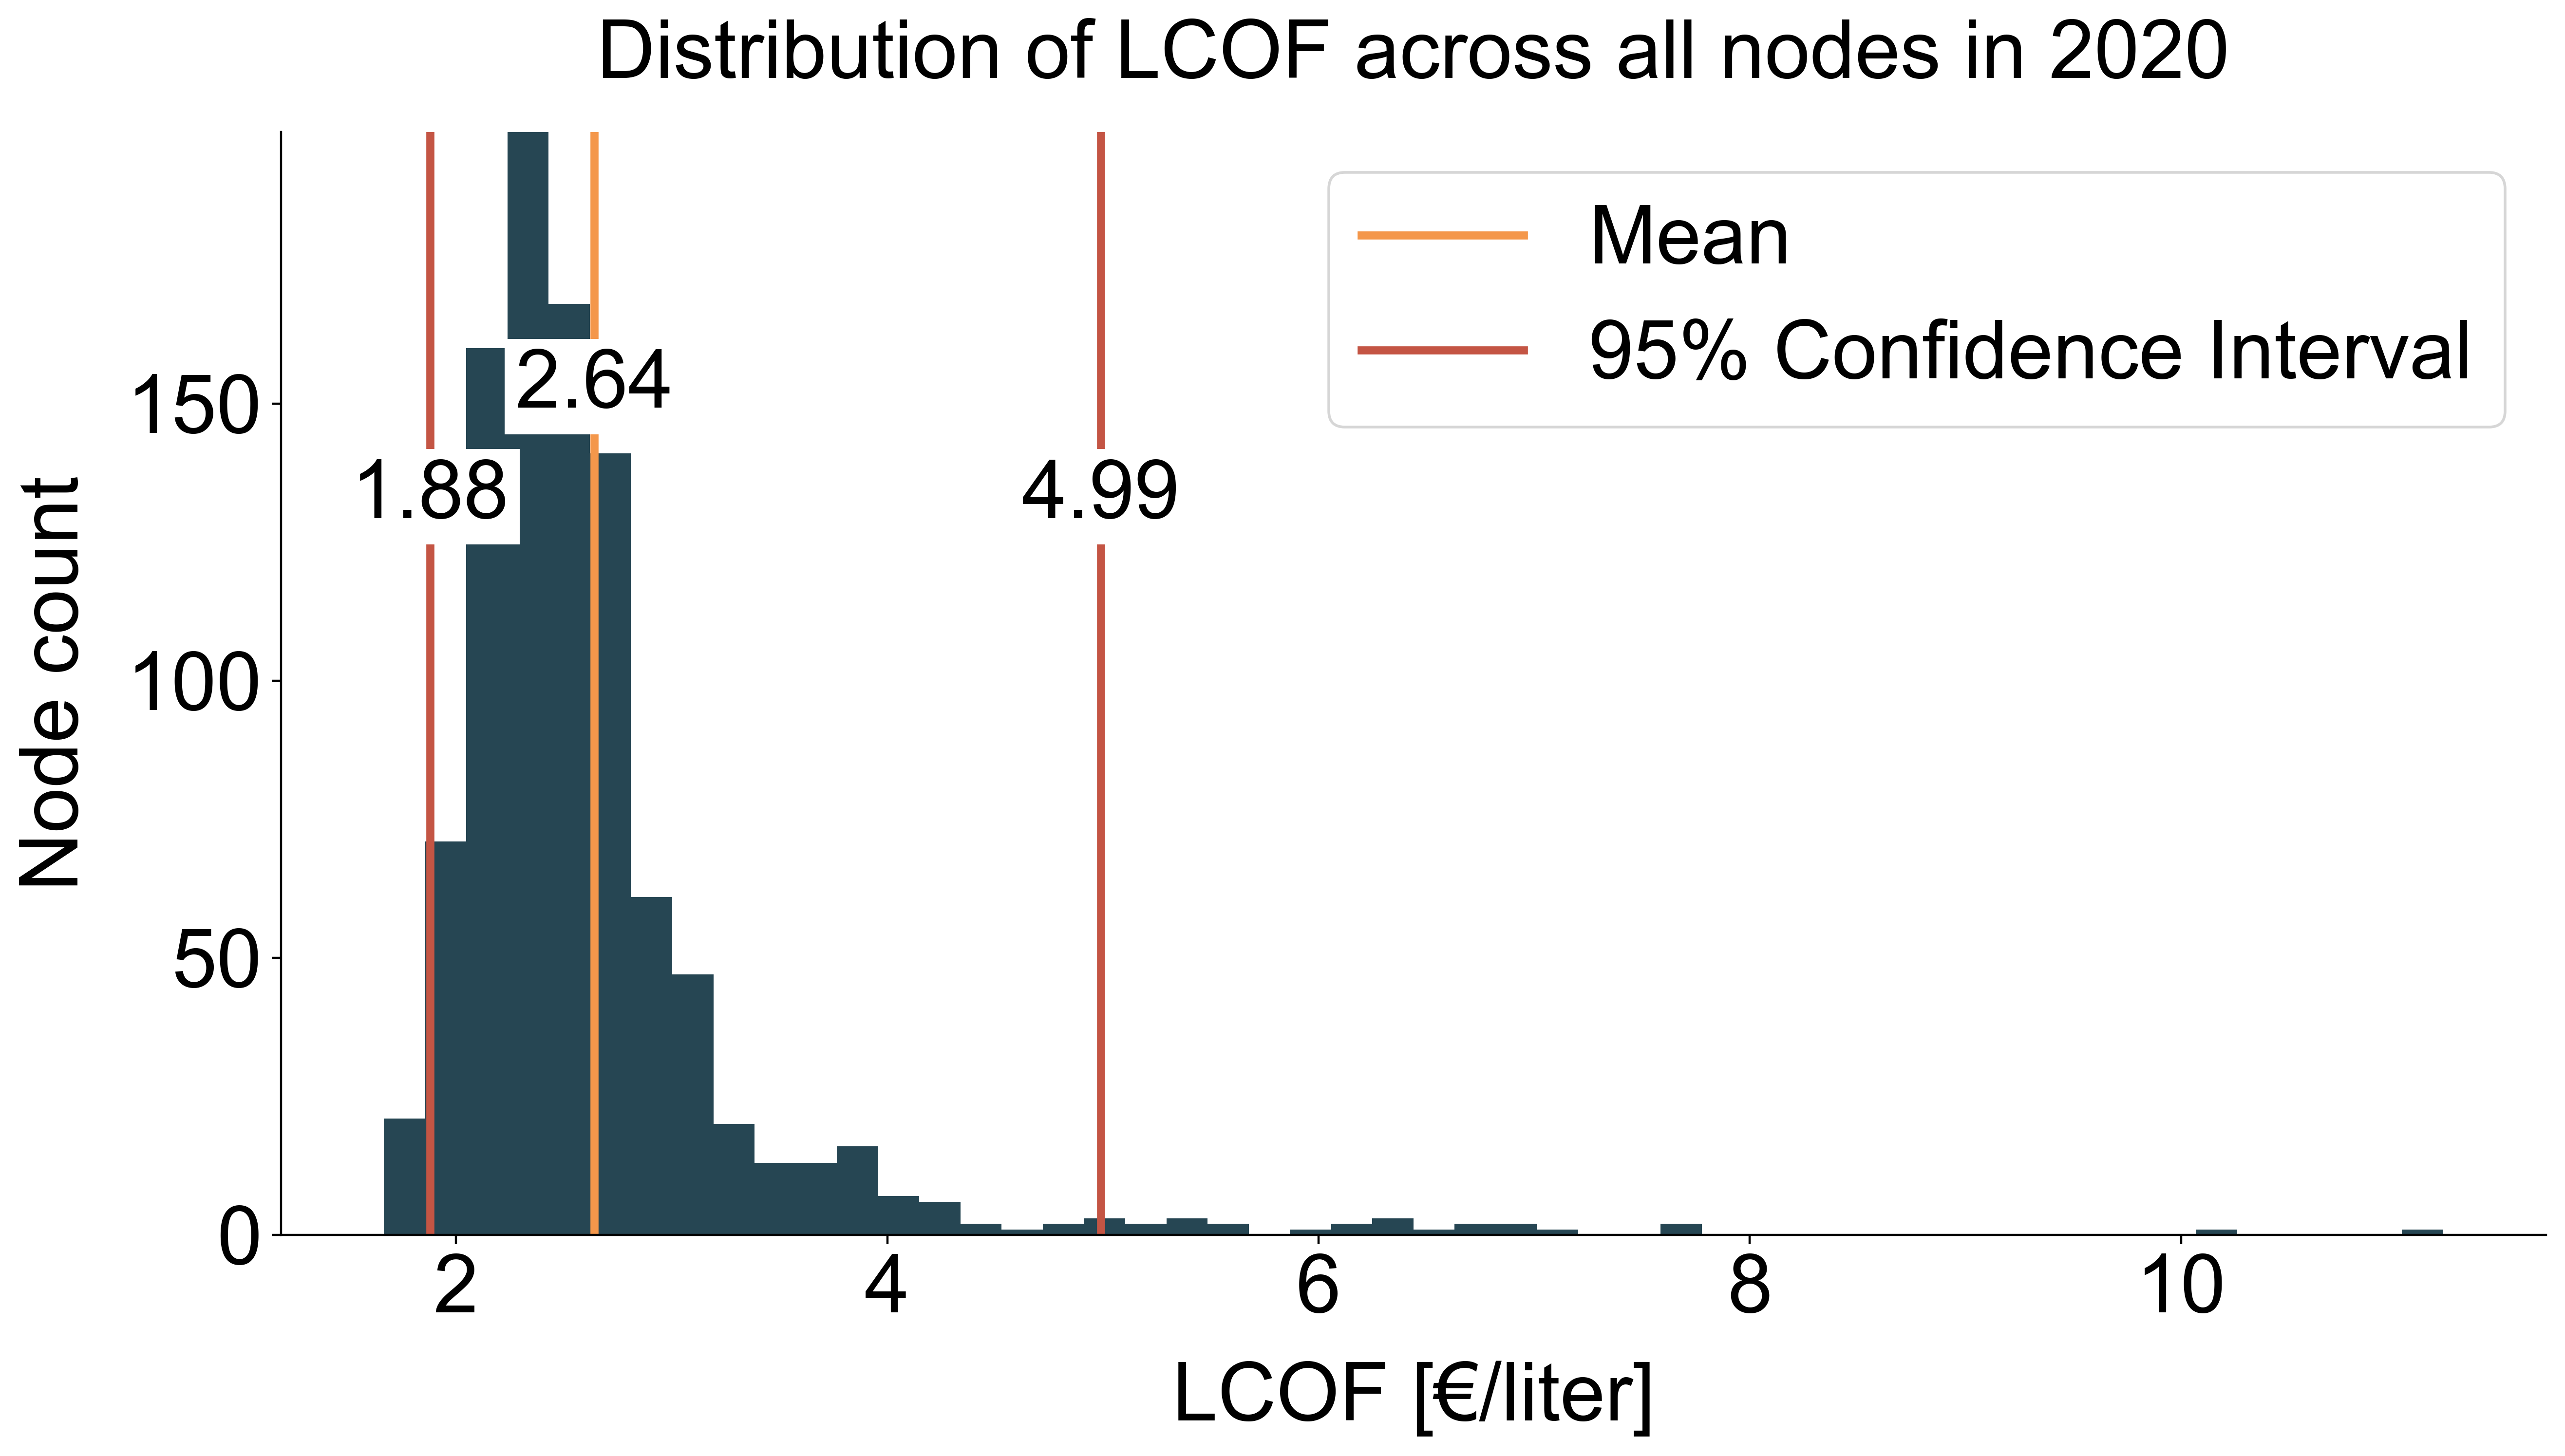

In [17]:
figsize=(15,7.5)
ymax = 199
plt.figure(figsize=figsize)
fontsize=figsize[0]*2
ax = combined_gdf.LCOF_liter_sensi.hist(bins=50)
ax.axvline(combined_gdf.LCOF_liter_sensi.mean(), linewidth=3,c='C1',label='Mean')
ax.text(combined_gdf.LCOF_liter_sensi.mean(),ymax*0.75, round(combined_gdf.LCOF_liter_sensi.mean(),2), fontsize=fontsize, horizontalalignment='center',
        bbox={'facecolor':'white','edgecolor':(0,0,0,0)})
ax.axvline(combined_gdf.LCOF_liter_sensi.quantile(0.025),linewidth=3,c='C2',label='95% Confidence Interval')
ax.text(combined_gdf.LCOF_liter_sensi.quantile(0.025),ymax*0.65, round(combined_gdf.LCOF_liter_sensi.quantile(0.025),2), fontsize=fontsize, horizontalalignment='center',
        bbox={'facecolor':'white','edgecolor':(0,0,0,0)})
ax.axvline(combined_gdf.LCOF_liter_sensi.quantile(0.975),linewidth=3,c='C2',)
ax.text(combined_gdf.LCOF_liter_sensi.quantile(0.975),ymax*0.65, round(combined_gdf.LCOF_liter_sensi.quantile(0.975),2), fontsize=fontsize, horizontalalignment='center',
        bbox={'facecolor':'white','edgecolor':(0,0,0,0)})
ax.set_xlabel('LCOF [€/liter]',fontsize=fontsize)
ax.set_ylabel('Node count',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(b=None)
ax.set_ylim(0,ymax)
ax.set_title('Distribution of LCOF across all nodes in 2020',fontsize=fontsize,pad=20)
ax.legend(fontsize=fontsize);

# plt.savefig('../../gfx/LCOF_distribution.png',dpi=400)

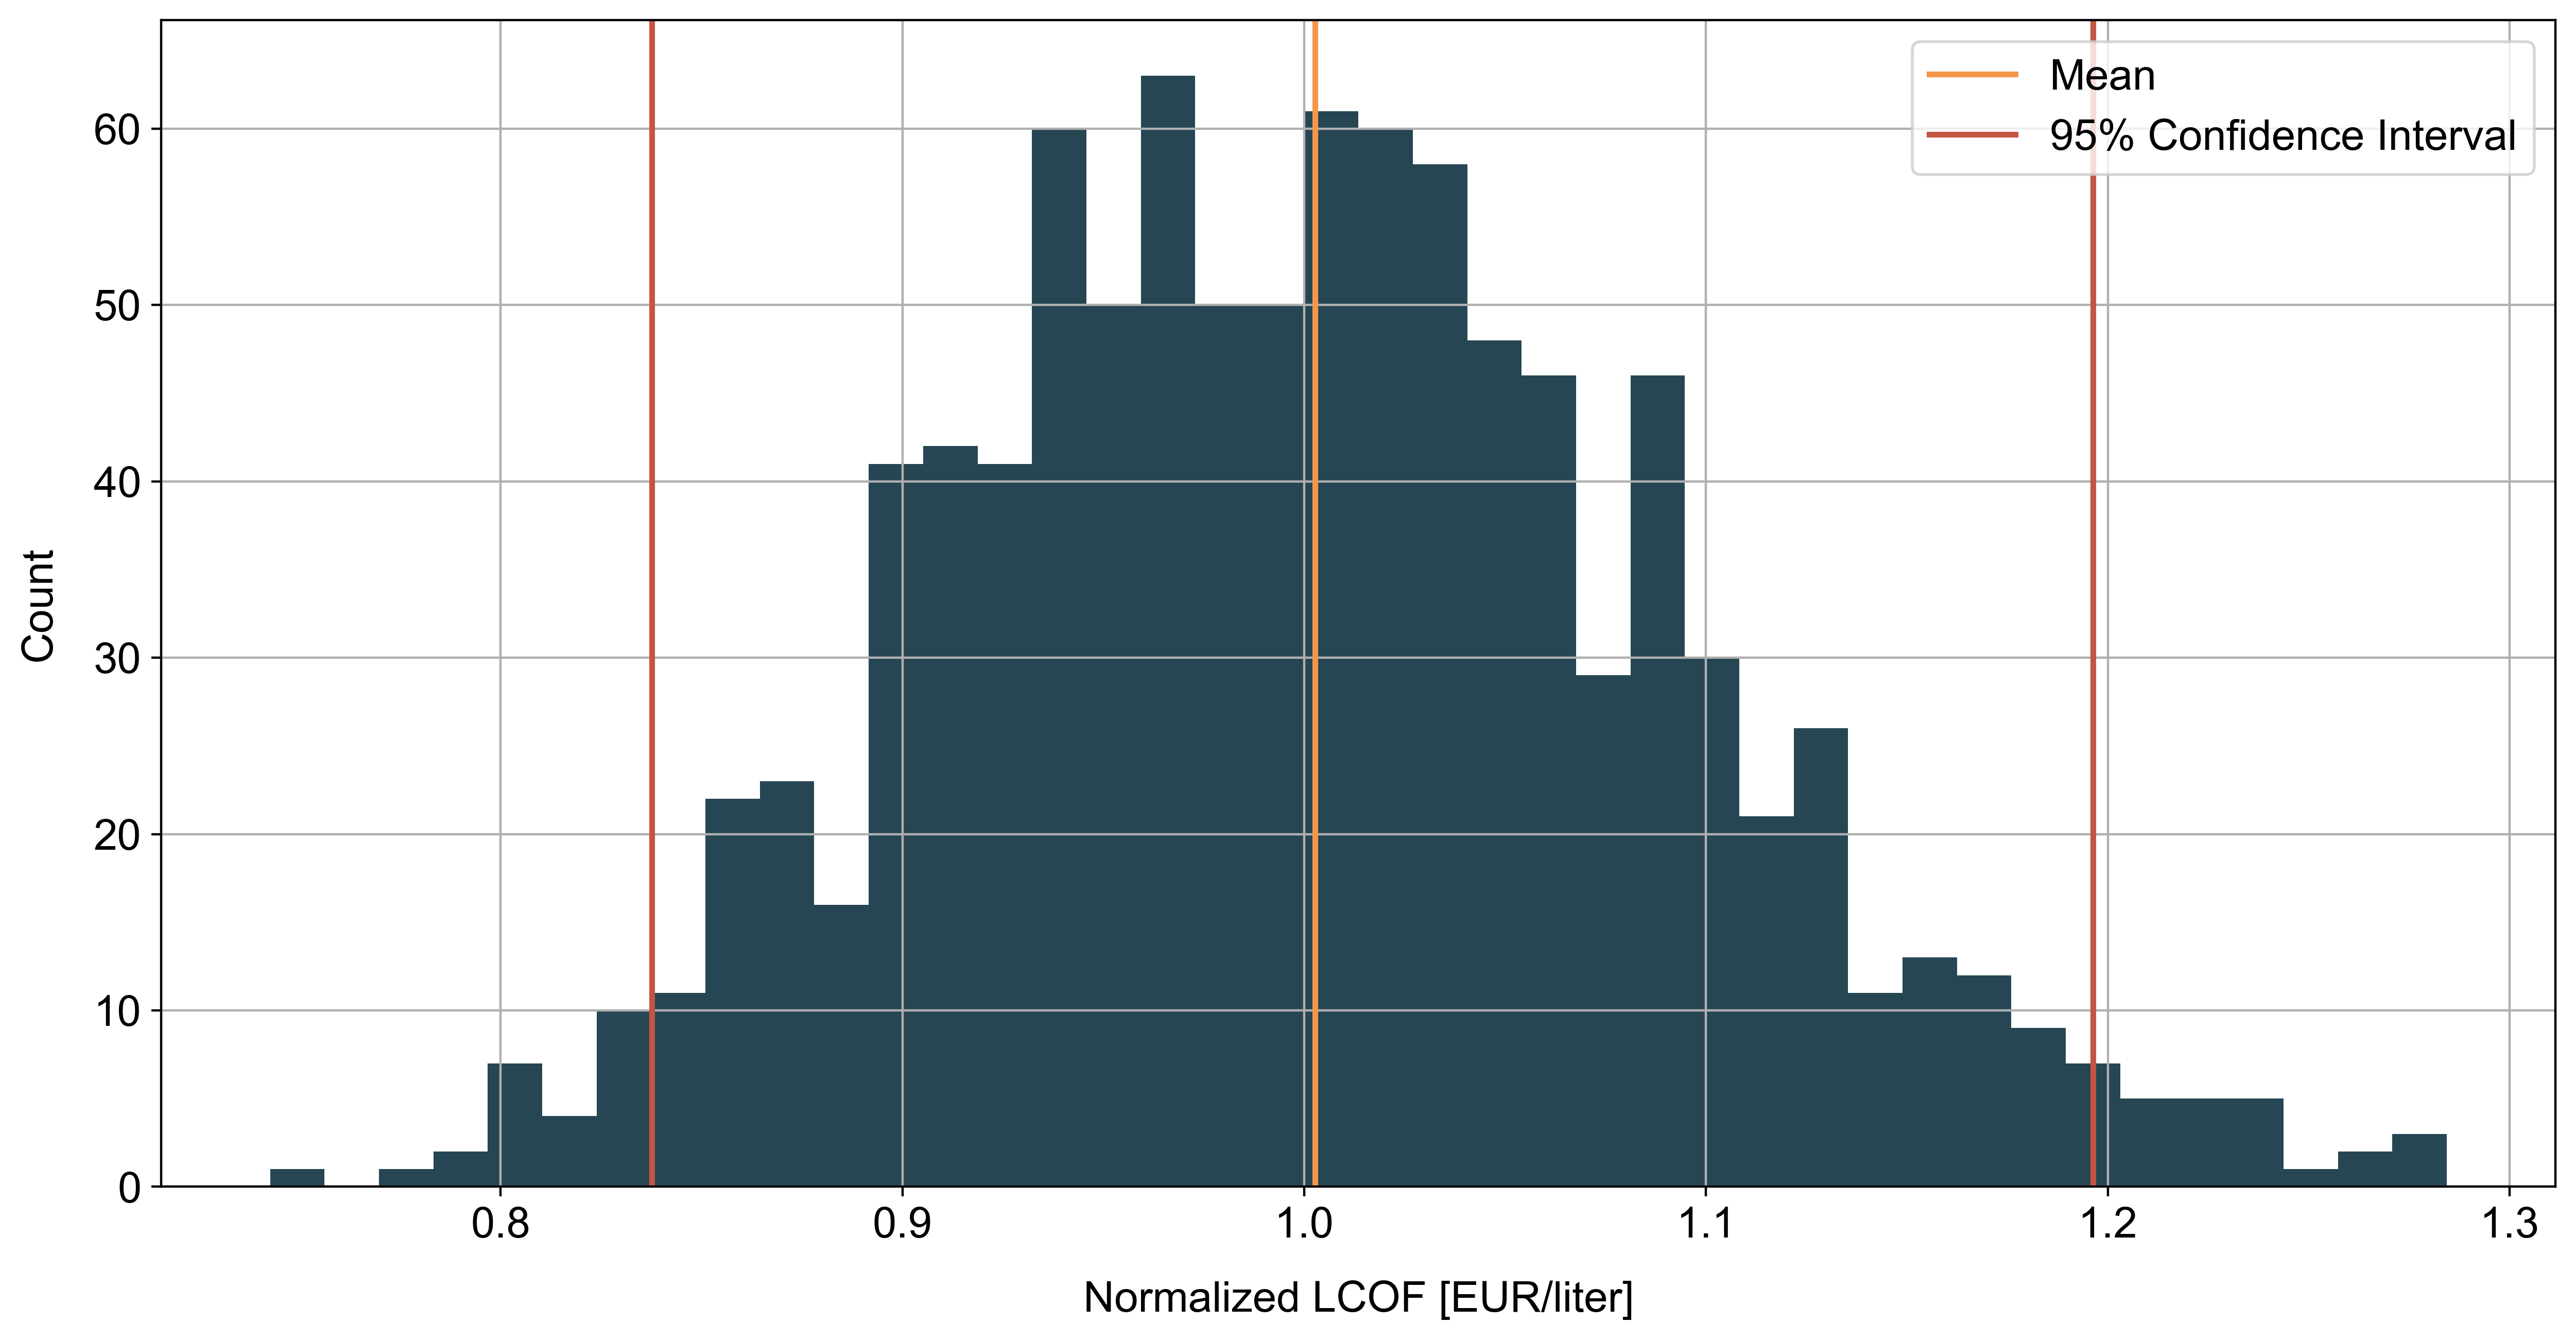

In [19]:
plt.figure(figsize=(15,7.5))
ax = combined_gdf.LCOF_liter_norm.hist(bins=40)
ax.axvline(combined_gdf.LCOF_liter_norm.mean(),c='C1',label='Mean')
ax.axvline(combined_gdf.LCOF_liter_norm.quantile(0.025),c='C2',label='95% Confidence Interval')
ax.axvline(combined_gdf.LCOF_liter_norm.quantile(0.975),c='C2',)
ax.set_xlabel('Normalized LCOF [EUR/liter]')
ax.set_ylabel('Count')
ax.legend();